In [1]:
from glob import glob
import torch
from os import listdir
from os.path import splitext
import logging, librosa
from torch.utils.data import Dataset
import numpy as np
import torch
from spectrogram import Spectrogram
from matplotlib import cm
from librosa import display
import matplotlib.pyplot as plt
from PIL import Image
import scipy.signal as signal
from sklearn import preprocessing
from torch.utils.data import DataLoader, random_split
import torchvision.utils as vutils
import torchvision.transforms as transforms
import os
from itertools import islice
%matplotlib inline

In [2]:
path="/Users/zombie/Downloads/datadrive/ljspeech/wavs/"
revPath="/Users/zombie/Downloads/datadrive/ljspeech/revWavs/"
checkpoint="/Users/zombie/2.5kDice.pt"

In [3]:
from glob import glob
from os import listdir
import numpy as np
from itertools import chain, cycle
from torch.utils.data import IterableDataset
import torchvision.transforms as transforms
import librosa, torch, random

In [38]:
class TestDataset(IterableDataset):
    def __init__(self, wavPath, samplingRate, nfft, winLength, window, shuffle=True):
        self.sr = samplingRate
        self.nfft = nfft
        self.window = window
        self.winLength = winLength
        self.wavPath = wavPath
        self.ids = [i for i in listdir(wavPath) if not i.startswith('.')]

        if shuffle:
            random.shuffle(self.ids)

    def __len__(self):
        return len(self.ids)

    def transform(self, X):
        return (X - X.min()) / (X.max() - X.min())

    def squaredChunks(self, spec):
        n = self.nfft // 2
        l = spec.shape[1]
        for i in range(0, l - l % n, n):
            yield np.expand_dims(spec[:, i:i + n], axis=0)

    def getAudio(self, idx):
        org = glob(self.wavPath + idx)[0]
        org, _ = librosa.load(org, sr=self.sr)
        
        stft=librosa.stft(org, n_fft=self.nfft, window=self.window, win_length=self.winLength)
        mag, phase=Spectrogram.complexToPolar(stft)
        magArray = self.transform(torch.FloatTensor(list(self.squaredChunks(np.abs(mag[1:])))))
        phaseArray = self.transform(torch.FloatTensor(list(self.squaredChunks(phase[1:]))))
        breakpoint()
        for idx, subArray in enumerate(magArray):
            yield (subArray**2, phaseArray[idx])

    def getStream(self, ids):
        yield from chain.from_iterable(map(self.getAudio, ids))

    def __iter__(self):
        return self.getStream(self.ids)


In [ ]:
class Audio():
    def __init__(self, magTensor, phaseTensor, samplingRate=16000):
        self.magTensor=magTensor
        self.phaseTensor=phaseTensor
        self.sr=samplingRate
        
    def 

In [39]:
dset=TestDataset(path, samplingRate=16000,  nfft=1024, winLength=32, window='hamming', shuffle=True)

In [40]:
trainLoader=DataLoader(dset, batch_size=12, shuffle=False, num_workers=0)

In [41]:
batch=trainLoader.__iter__().__next__()

> <ipython-input-38-bdb67d398d6e>(34)getAudio()
     32         phaseArray = self.transform(torch.FloatTensor(list(self.squaredChunks(phase[1:]))))
     33         breakpoint()
---> 34         for idx, subArray in enumerate(magArray):
     35             yield (subArray**2, phaseArray[idx])
     36 



ipdb>  c


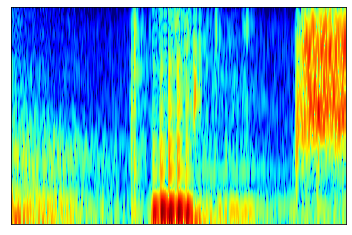

In [50]:
librosa.display.specshow(librosa.power_to_db(batch[0][2][0]), cmap=cm.jet)

In [30]:
batch.shape

torch.Size([12, 1, 512, 512])

In [157]:
def squaredChunks(spec, n=2):
    l = len(spec)
    pp=[]
    for i in range(0, n, l+1):
        print(i)

        pp.append(np.expand_dims(spec[i:i+n], axis=0))
        breakpoint()
    return pp

In [158]:
squaredChunks([i for i in range(10)])

0
> <ipython-input-157-91003ee072ba>(4)squaredChunks()
      2     l = len(spec)
      3     pp=[]
----> 4     for i in range(0, n, l+1):
      5         print(i)
      6 



ipdb>  p n


2


ipdb>  p l+1


11


ipdb>  q


BdbQuit: 

In [ ]:
t=np.random.randn(3,6)

In [167]:
def squaredChunks(spec, n=256):
    l = spec.shape[1]
    for i in range(0, l-l%n, n):
        yield np.expand_dims(spec[:,i:i+n], axis=0)

In [172]:
tt=np.asarray(list(squaredChunks(t, n=3)))

0
(1, 3, 3)
3
(1, 3, 3)


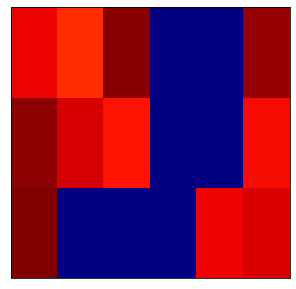

In [117]:
plt.figure(figsize=(5,5))
# plt.figsize((5,5))
librosa.display.specshow(librosa.power_to_db(t), cmap=cm.jet)


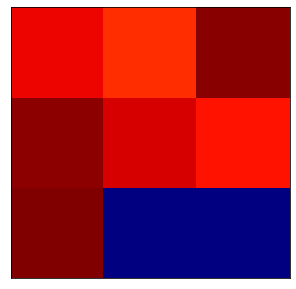

In [174]:
plt.figure(figsize=(5,5))
# plt.figsize((5,5))
librosa.display.specshow(librosa.power_to_db(tt[0][0]), cmap=cm.jet)


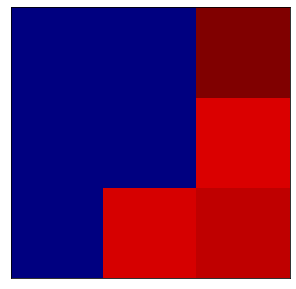

In [175]:
plt.figure(figsize=(5,5))
# plt.figsize((5,5))
librosa.display.specshow(librosa.power_to_db(tt[1][0]), cmap=cm.jet)


In [4]:
dset=TrainDataset(path, revPath, samplingRate=16000, segmentLength=16000, nfft=512, winLength=32, window='hamming', shuffle=True)

In [6]:
loader=DataLoader(dset, batch_size=32)
i=0
for batch in islice(loader, 2):  
    print('yes {}'.format(i), end="\r")
    i+=1

In [6]:
batch[0].shape

torch.Size([32, 1, 256, 256])

In [67]:
from unet import UNet
net=UNet(1, 1)
checkpoint=torch.load(checkpoint, map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['modelStateDict'])

<All keys matched successfully>

In [56]:
def countParams(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [57]:
countParams(net)

226960388

In [68]:
out=net(batch[0])

In [69]:
temp1=out[4][0]
# temp1=(temp1*0.5)+0.5
temp=batch[0][4][0]
# temp2=(temp2*0.5)+0.5